In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
import numpy as np
import missingno as msno

from datetime import datetime

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import helper


### Driver Code


In [97]:
PLOT_WIDTH, PLOT_HEIGHT = (1000, 500)
helper._init()


Misc Folder located!
Plots Folder located!


In [98]:
df = helper.fetch_data_from_database(
    table="mobility_stats_apple",
    where_column="region",
    where_value="Greece",
    date_column="date",
)


Creating connection to the PostgreSQL database...
Opening connection...
Data Fetched


<AxesSubplot:>

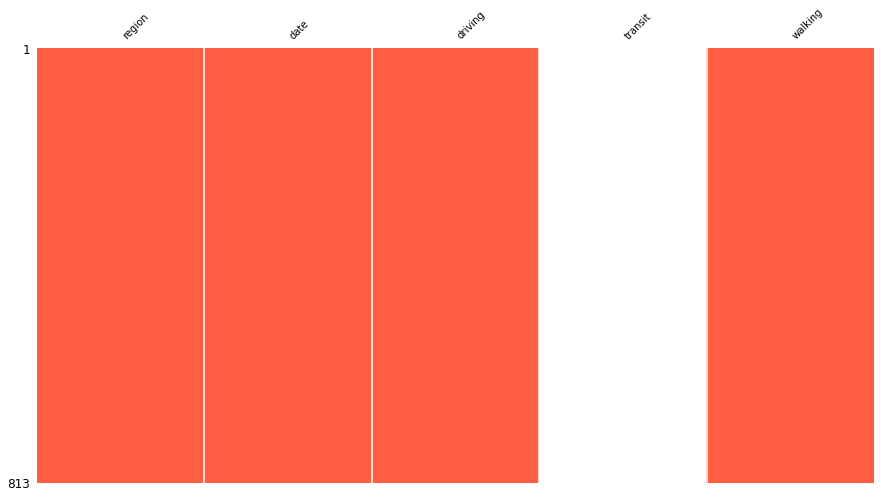

In [99]:
msno.matrix(df, figsize=(15, 8), fontsize=10, sparkline=False, color=(1, 0.38, 0.27))


In [100]:
df.dtypes


region             object
date       datetime64[ns]
driving           float64
transit            object
walking           float64
dtype: object

In [101]:
# Convert columns to their appropriate types
df["transit"] = df["transit"].astype("float64")


In [102]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
driving,813.0,134.428487,73.150368,18.59,75.38,125.84,174.48,364.78
transit,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
walking,813.0,161.018352,104.175647,18.00,74.30,142.48,207.85,456.68


In [103]:
num_cols = [column for column in df.columns if df[column].dtype == "float64"]
df = helper.preproccess_pipeline(
    df=df, numeric_columns=num_cols, group_subset="date", threshold=0.8
)


Step 1: Checking for null columns...
--- Found null column: transit
Step 2: Checking for duplicate entries...
--- No duplicate entries found
Step 3: Dropping samples that have more than 20% missing values
Step 4: Fill remaining null values with forward fill method


In [104]:
df["day_name"] = df["date"].dt.day_name()


In [105]:
skewed_cols = [col for col in df.columns[2:-1] if np.abs(df[col].skew()) > 0.5]


In [106]:
fig = px.histogram(
    data_frame=df,
    x=skewed_cols,
    histnorm="percent",
    nbins=50,
    facet_col="variable",
    facet_col_wrap=2,
    facet_col_spacing=0.03,
    width=600 * len(skewed_cols),
    height=PLOT_HEIGHT * len(skewed_cols) / 2,
)
fig.update_layout(
    showlegend=False,
    bargap=0.2,
    yaxis=dict(title_text="Frequency"),
    title_text="Feature Histogram with skew > 0.5",
    title_x=0.5,
)
fig.update_xaxes(title_text="Value", position=0.5, ticksuffix="%")
fig.update_yaxes(matches=None, showticklabels=True, ticksuffix="%")
fig.for_each_annotation(
    lambda a: a.update(
        text=f'{a.text.split("=")[-1].title()}: {np.abs(df[a.text.split("=")[-1]].skew()):.2f}'
    )
)

fig.show()
fig.write_image("../plots/Skewed Features (Histogram)(Apple).png")


In [107]:
fig = px.line(
    data_frame=df,
    x="date",
    y=skewed_cols,
    width=PLOT_WIDTH,
    height=PLOT_HEIGHT,
    labels=dict(value="Change (%)"),
)

fig.add_vrect(
    x0=datetime(2020, 5, 1),
    x1=datetime(2020, 9, 1),
    fillcolor="goldenrod",
    opacity=0.2,
    line_width=0,
)
fig.add_vrect(
    x0=datetime(2021, 5, 1),
    x1=datetime(2021, 9, 1),
    fillcolor="goldenrod",
    opacity=0.2,
    line_width=0,
)

fig.for_each_annotation(lambda a: a.update(text=f'{a.text.split("=")[-1]}'))
fig.show()
fig.write_image("../plots/Skewed Features (Line)(Apple).png")


In [108]:
df_corr = df.corr(method="spearman")
labels = np.where(
    np.abs(df_corr) > 0.90,
    "VS",
    np.where(
        np.abs(df_corr) > 0.75,
        "S",
        np.where(np.abs(df_corr) > 0.55, "M", np.where(np.abs(df_corr) > 0.30, "W", "")),
    ),
)


In [109]:
fig = px.imshow(
    df_corr, width=1200, height=500, text_auto=".2f", color_continuous_scale="RdBu_r"
)

fig.update_layout(
    title="Feature Relationships",
)
fig.update_traces(text=labels, texttemplate="%{text}")
fig.show()


In [42]:
fig = px.scatter(
    df,
    x="driving",
    y="walking",
    color="day_name",
    facet_col="day_name",
    facet_col_wrap=3,
    labels={"walking": "", "driving": ""},
    title="Driving vs Walking on Daily Basis",
    width=300 * 3,
    height=200 * 3,
)
fig.update_layout(showlegend=False)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.show()
fig.write_image("../plots/Mobility Behavior per Day of Week.png")

In [111]:
n_train = int(df.shape[0] * 0.85)
train, test = (
    df.loc[:n_train, ("driving", "walking")],
    df.loc[n_train:, ("driving", "walking")],
)


In [112]:
fig = px.scatter(
    train,
    x="driving",
    y="walking",
    width=1000,
    height=600,
    trendline="lowess",
    trendline_scope="overall",
    trendline_color_override="red",
)

fig.show()


In [114]:
def exponential(x, a, b, c):
    return a * np.exp(x * b) + c * x


In [115]:
x_train, y_train = train['driving'], train['walking']

In [116]:
sorted_x = {x: y for x, y in zip(x_train, y_train)}
sorted_x = dict(sorted((k, v) for (k, v) in sorted_x.items()))

x_train = np.asarray([k for k in sorted_x.keys()])
y_train = np.asarray([v for v in sorted_x.values()])

In [117]:
pars, cov = curve_fit(f=exponential, xdata=x_train, ydata=y_train, p0=[0, 0, 0], bounds=(-np.inf, np.inf))
res = y_train - exponential(x_train, *pars)

In [118]:
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{"colspan": 2}, None], [{}, {}]],
    horizontal_spacing=0.02,
    vertical_spacing=0.05,
    subplot_titles=["Exponential Fitting", "Residuals", "Residual Scatterplot"],
)
fig.add_trace(go.Scatter(x=x_train, y=y_train, mode="markers", name="Original Data"), row=1, col=1)
fig.add_trace(
    go.Scatter(x=x_train, y=exponential(x_train, *pars), mode="lines", name="Fitted Curve", line_width=3),
    row=1,
    col=1,
)
fig.add_trace(go.Scatter(x=x_train, y=res, mode="markers", showlegend=False), row=2, col=1)
fig.add_trace(go.Histogram(x=res, nbinsx=50, showlegend=False), row=2, col=2)

fig.update_layout(
    width=PLOT_WIDTH * 1.5,
    height=PLOT_HEIGHT * 2,
    title_text="Curve Fitting Results",
    title_x=0.5,
    bargap=0.2,
)
fig.show()
fig.write_image("../plots/Curve Fitting Results (Apple).png")


In [122]:
print(f"R2-score: {r2_score(y_true=y_train, y_pred=exponential(x_train, *pars)):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true=y_train, y_pred=exponential(x_train, *pars))):.3f}")

R2-score: 0.928
RMSE: 30.119


In [120]:
x_test, y_test = test['driving'], test['walking']

In [121]:
print(f"R2-score: {r2_score(y_true=y_test, y_pred=exponential(x_test, *pars)):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_true=y_test, y_pred=exponential(x_test, *pars))):.3f}")

R2-score: 0.466
RMSE: 28.863
